# xFRQI – Guía de Uso Rápido (Notebook)

Este notebook implementa y valida el modelo **xFRQI multicanal**, donde cada **qubit de color** codifica una imagen (o atributo) diferente.  

Se comparan tres representaciones del mismo estado cuántico:

1. **Teórico (fórmula analítica)**  
2. **Circuito (statevector) – lightning.qubit**  
3. **Muestreo (√p) – default.qubit**

---

## ✔ Propósito del Notebook

- Validar que **la fórmula del xFRQI** coincide con **el circuito cuántico**.  
- Validar que **el muestreo (√p)** coincide con el **statevector** dentro del error estadístico.  
- (Opcional) Reconstruir imágenes y explorar métricas o correlaciones.

---

## ✔ Orden recomendado de ejecución

1. **Teórico vs Circuito**  
   Confirma que la implementación del circuito `encode()` es correcta.

2. **Circuito vs Muestreo (√p)**  
   Confirma la consistencia entre amplitudes y conteos con `shots > 0`.

3. **(Opcional)** Reconstrucción, métricas, correlaciones, etc.

---

## ✔ Dispositivos recomendados

- **`lightning.qubit`**  
  Simulador por statevector (rápido y preciso).  
  → usado para “Circuito (statevector)”.

- **`default.qubit`**  
  Simulador basado en muestreo (tipo hardware).  
  → usado para “Muestreo (√p)”.

---

## ✔ Canales de color (xFRQI)

- Con `n_color_qubits = C` el modelo codifica **C imágenes/canales**.  
  (cada qubit de color representa un canal independiente)

- Las imágenes deben pasarse en orden: **[MSB → LSB]**

  Ejemplo para 2 qubits de color:  
  ```python
  images = [img0, img1]

  - Si usas una sola imagen, se replica en todos los canales.

- Parámetros sugeridos
  - `image_size` = potencia de 2 (4, 8, 16, …)
  - `device_exact = "lightning.qubit"`
  - `device_sampling = "default.qubit"`
  - `shots = 8192` o `16384` para reducir error ~ 1/√shots
  - `threshold_exact = 1e-6`, `threshold_samp = 1e-3`

- Imports y modelo (ejemplo)
  - `from src import FRQI, FRQI2, FRQI3, generate_image, select_frqi`
  - `Model = select_frqi(n_color_qubits)`
  - `model = Model(image_size, device=device_exact)`

- Lectura de resultados
  - “Teórico (fórmula)” ≈ “Circuito (statevector)” → valida la implementación del encode.
  - “Circuito (statevector)” ≈ “Muestreo (√p)” → valida el conteo estadístico (diferencias ↓ con más shots).


In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

project_root = os.path.dirname(os.getcwd()) if "notebooks" in os.getcwd() else os.getcwd()
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(f"📂 Proyecto cargado desde: {project_root}")

from src import FRQI, FRQI2, FRQI3, generate_image, select_frqi

📂 Proyecto cargado desde: c:\Users\ometi\Documents\IA\Github\FRQI_project


# FRQI: Modelo y Flujo de Codificación

## 1. Representación de Imágenes

Las posibilidades de codificacion de imágenes en computación cuántica son variadas con modelos que aprovechan tanto las amplitudes, fases o estados base de una funcion de onda cuántica para codificar la información. Aquí nos centramos en el modelo **FRQI** (Flexible Representation of Quantum Images), que permite una expansion para manejar múltiples canales usando los correspondientes qubits en los cuales podemos anexar informacion de color o otras imágenes en escala de grises por ejemplo.
El modelo original **FRQI** representa una imagen de $P$ píxeles mediante una superposición cuántica de estados donde:

- Las **posiciones** de los píxeles se codifican en los estados base
- Las **intensidades de color** se codifican en las amplitudes mediante ángulos de rotación
 
 En el siguiente bloqeu peudes definir cuantos canales de color deseas manejar y el tamaño de las imagenes a codificar.


Modelo: FRQI2 | Qubits color: 2 | Dispositivo exacto: lightning.qubit


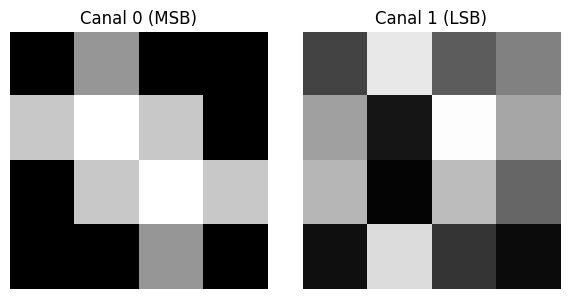

In [14]:
# Configuración de parámetros y devices a utilizar
image_size = 4  # image_size debe ser potencia de 2 (4, 8, 16, ...)
n_color_qubits = 2  # 1 | 2 | 3

device_exact = "lightning.qubit"
device_sampling = "default.qubit"
shots = 8192

threshold_exact = 1e-6
threshold_samp = 1e-3

# Validación
assert (image_size & (image_size - 1)) == 0, "image_size debe ser potencia de 2 (4, 8, 16, ...)"

# Construir modelo
Model = select_frqi(n_color_qubits)
model = Model(image_size, device=device_exact)
print(f"Modelo: {Model.__name__} | Qubits color: {n_color_qubits} | Dispositivo exacto: {device_exact}")

# ----------------------------------------------------
# Generar tantas imágenes como qubits de color (xFRQI)
# ----------------------------------------------------
images = []
for k in range(n_color_qubits):
    if k == 0:
        # primer canal: patrón
        img = generate_image(image_size=image_size, use_pattern=True)
    else:
        # canales restantes: aleatorios con seeds distintas
        img = generate_image(image_size=image_size, use_pattern=False, seed=42 + k)
    images.append(img)

# Visualización rápida
fig, axs = plt.subplots(1, n_color_qubits, figsize=(3 * n_color_qubits, 3))
if n_color_qubits == 1:
    axs = [axs]  # para indexar de forma uniforme

for k, ax in enumerate(axs):
    ax.imshow(images[k], cmap="gray", vmin=0, vmax=255)
    ax.set_title(f"Canal {k} ({'MSB' if k == 0 else 'LSB' if k == n_color_qubits - 1 else ''})")
    ax.axis("off")

plt.tight_layout()
plt.show()


# Representación Cuántica Multicanal (xFRQI) Analisis

El modelo **xFRQI (extended Flexible Representation of Quantum Images)** permite codificar múltiples imágenes o atributos en un único estado cuántico.  

Su estructura separa la información en dos tipos de registros:

- **Qubits de posición**: codifican el índice del píxel en los estados base.  
- **Qubits de color**: cada uno representa un *canal* independiente (por ejemplo, dos imágenes en paralelo, componentes RGB, kernels, mapas de características, etc.).

Este notebook utiliza **qubits de color** (`n_color_qubits = 2`) para codificar *dos imágenes distintas* como canales:  
- Canal **MSB** → primera imagen  
- Canal **LSB** → segunda imagen  


---

## 1. Configuración del Registro Cuántico

Sea `image_size × image_size` una imagen con `P = image_size^2` píxeles.

Numero total de qubits:

$$

n_{\text{qubits}} = n_{\text{color}} + n_{\text{pos}}, 
\quad 
n_{\text{pos}} = \lceil \log_2(P) \rceil.

$$

Un detalle técnico que peude ahorrarnos mucha confusión es el orden de los que qubits se ordenan en convención **big-endian**:

### Desglose de Wires

| Rango de Wires | Función | Descripción |
|----------------|---------|-------------|
| `0 ... n_pos-1` | Posición | Codifican la ubicación del píxel (MSB → LSB) |
| `n_pos ... n_qubits-1` | Color | Codifican la intensidad/canal de color (MSB → LSB) |

### Mapeo de Índice Base (detalle pero importante)

El índice del estado base se calcula como:

$$
\text{idx} = (\text{pos\_idx} \ll n_{\text{color}}) \,|\, \text{color\_bits}
$$

donde:
- `pos_idx`: índice de posición del píxel
- `color_bits`: bits del color en formato binario (MSB → LSB)
- `<<` : operador de desplazamiento a la izquierda (shift left)
- `|` : operador OR bit a bit

**Ejemplo:** Para `n_color = 1`, píxel en posición 3, color claro (bit=0):
$$
\text{idx} = (3 \ll 1) | 0 = 6 + 0 = 6 \quad \rightarrow \quad |110\rangle
$$

---

## 3. Ángulos y Normalización

### Codificación de Intensidad

Ahora para cada canal $k$ y píxel en posición $i$, el ángulo de rotación que afectara al qubit representante del canal y se define como:

$$
\theta_k(i) = \frac{\pi}{2} \cdot \frac{I_k(i)}{255}
$$

donde:
- $I_k(i) \in [0, 255]$ es la "intensidad" del píxel en el canal $k$
- $\theta_k(i) \in [0, \pi/2]$ es el ángulo de rotación correspondiente

### Normalización por Superposición

La amplitud base se normaliza por la superposición uniforme de posiciones:

$$
\text{Amplitud base} = \frac{1}{\sqrt{P}}
$$

Esta normalización garantiza que la suma de las probabilidades de todos los estados sea 1.

---

## 4. Fórmula de Amplitudes

### Expresión General

La amplitud para un estado cuántico $|\text{pos}\rangle \otimes |\text{color\_bits}\rangle$ se calcula como:

$$
\alpha(\text{pos}, \text{color\_bits}) = \frac{1}{\sqrt{P}} \cdot \prod_{k=0}^{n_{\text{color}}-1} f_k(i)
$$

donde la función $f_k(i)$ se define según el bit $k$ del color:

$$
f_k(i) = \begin{cases}
\cos(\theta_k(i)) & \text{si el bit } k \text{ del color es } 0 \\
\sin(\theta_k(i)) & \text{si el bit } k \text{ del color es } 1
\end{cases}
$$

### Interpretación

- **Bit 0 (píxel oscuro)**: Usa $\cos(\theta)$ → valores bajos de intensidad dan amplitudes altas
- **Bit 1 (píxel claro)**: Usa $\sin(\theta)$ → valores altos de intensidad dan amplitudes altas

### Propiedad de Positividad

Dado que $\theta_k \in [0, \pi/2]$:

$$
\cos(\theta_k) \geq 0 \quad \text{y} \quad \sin(\theta_k) \geq 0
$$

Por lo tanto:

$$
\alpha(\text{pos}, \text{color\_bits}) \in \mathbb{R}^+ \quad \text{(coeficientes reales y no negativos)}
$$

**Implicación:** Todas las amplitudes en FRQI son reales y no negativas, lo que simplifica el análisis del estado cuántico.

---

## 5. Estado Cuántico Completo

El estado FRQI completo de una imagen se puede escribir como:

$$
|\psi\rangle = \frac{1}{\sqrt{P}} \sum_{i=0}^{P-1} \sum_{c=0}^{2^{n_{\text{color}}}-1} \alpha(i, c) \, |i\rangle \otimes |c\rangle
$$

donde:
- $|i\rangle$ representa la posición del píxel
- $|c\rangle$ representa el color/intensidad
- $\alpha(i, c)$ es la amplitud calculada según la fórmula anterior

### Normalización Total

El estado satisface la condición de normalización:

$$
\langle\psi|\psi\rangle = \sum_{i=0}^{P-1} \sum_{c=0}^{2^{n_{\text{color}}}-1} |\alpha(i, c)|^2 = 1
$$

**Implicación:** Detalle importante el estado resultante es un estado puro, lo que significa que puede ser descrito completamente por un vector de estado en el espacio de Hilbert correspondiente y la correspondiente entropia de von Neumann es cero.


# Proceso de Codificación xFRQI (Circuito Cuántico)

## 1. Pasos del Circuito

### Paso 1: Inicialización

Inicializamos todos los qubits en el estado fundamental:

$$
|\psi_0\rangle = |0\rangle^{\otimes n_{\text{qubits}}}
= \underbrace{|00\ldots0\rangle}_{\text{color}} \otimes \underbrace{|00\ldots0\rangle}_{\text{posición}}.
$$

Recordando que:

$$
n_{\text{qubits}} = n_{\text{color}} + n_{\text{pos}}.
$$

---

### Paso 2: Superposición de Posiciones

Aplicamos compuertas Hadamard a todos los qubits de **posición**:

$$
\left(\mathbb{I}^{\otimes n_{\text{color}}} \otimes H^{\otimes n_{\text{pos}}}\right)
|\psi_0\rangle \;\longrightarrow\; |\psi_1\rangle
= \frac{1}{\sqrt{P}} \sum_{i=0}^{P-1} 
|00\ldots0\rangle_{\text{color}} \otimes |i\rangle_{\text{pos}}.
$$

**Efecto:** Creamos una superposición uniforme sobre todas las posiciones de píxeles, dejando el registro de color en $|00\ldots0\rangle$.

---

### Paso 3: Codificación de Intensidades (Canales xFRQI)

Para cada píxel $i \in \{0,\ldots,P-1\}$ y cada canal de color $k \in \{0,\ldots,n_{\text{color}}-1\}$:

1. **Selección de posición (control lógico):**  
   El registro de posición actúa como **control**. La compuerta solo actúa cuando
   $|{\rm pos}\rangle = |i\rangle_{\text{pos}}$.
   A nivel de circuito, esto se implementa como una rotación multicontrolada usando los bits de $i$
   (MSB → LSB), con posibles compuertas $X$ auxiliares para ajustar controles y luego deshacerlos (*uncompute*).

2. **Rotación en el qubit de color $k$:**  
   Aplicamos una rotación $RY$ controlada:

$$
C^{n_{\text{pos}}}RY\bigl(2\theta_k(i)\bigr)
$$

   sobre el qubit de color $k$, donde el ángulo está dado por:

$$
2\theta_k(i) = \pi \cdot \frac{I_k(i)}{255},
$$

   e $I_k(i)$ es la intensidad del píxel $i$ en el canal $k$.

Este paso construye, para cada posición $i$, el estado de color

$$
|C(i)\rangle = \bigotimes_{k=0}^{n_{\text{color}}-1}
\left[\cos\theta_k(i)\,|0\rangle + \sin\theta_k(i)\,|1\rangle\right],
$$

vinculado a $|i\rangle_{\text{pos}}$.

---

### Paso 4: Estado Final xFRQI

Después de codificar todos los píxeles y canales, el estado resultante es:

$$
|\psi_{\text{final}}\rangle 
= \frac{1}{\sqrt{P}}
\sum_{i=0}^{P-1}
\sum_{c=0}^{2^{n_{\text{color}}}-1}
\alpha(i,c)\;
|c\rangle_{\text{color}} \otimes |i\rangle_{\text{pos}},
$$

donde $\alpha(i,c)$ se obtiene de la regla de amplitudes:

$$
\alpha(i,c)
= \frac{1}{\sqrt{P}}
\prod_{k=0}^{n_{\text{color}}-1}
f_k(i),
$$

con

$$
f_k(i) = 
\begin{cases}
\cos\theta_k(i), & \text{si el bit } k \text{ de } c \text{ es } 0,\\[4pt]
\sin\theta_k(i), & \text{si el bit } k \text{ de } c \text{ es } 1.
\end{cases}
$$

Este es el estado xFRQI multicanal que utilizaremos para comparar:
- la **fórmula teórica**,
- el **statevector del circuito**, y
- el **muestreo** ($\sqrt{p}$).


## Teórico vs Circuito
* Teórico (fórmula): theoretical_state(...) calcula |ψ⟩ analíticamente con la fórmula FRQI.
* Circuito (statevector): encode(...) ejecuta el circuito y devuelve |ψ⟩ del simulador.
* Validación de modelo: |Teórico| ≈ |Circuito| con diferencias numéricas típicas ~1e−12…1e−8.

## Medición y Muestreo
* Statevector ("exacto"): lee |ψ⟩ y obtén |α_j| directamente; requiere backend de statevector (p. ej., lightning.qubit).
* Muestreo ("hardware‑like"): mide en base computacional con shots > 0, estima p_j ≈ N_j/shots y compara |α_j| ≈ √p_j.
* Error esperado por muestreo: O(1/√shots); aumentar shots reduce la discrepancia.

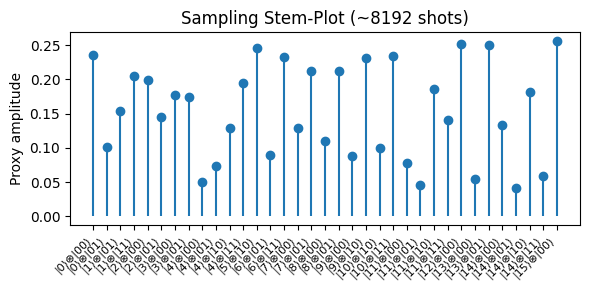

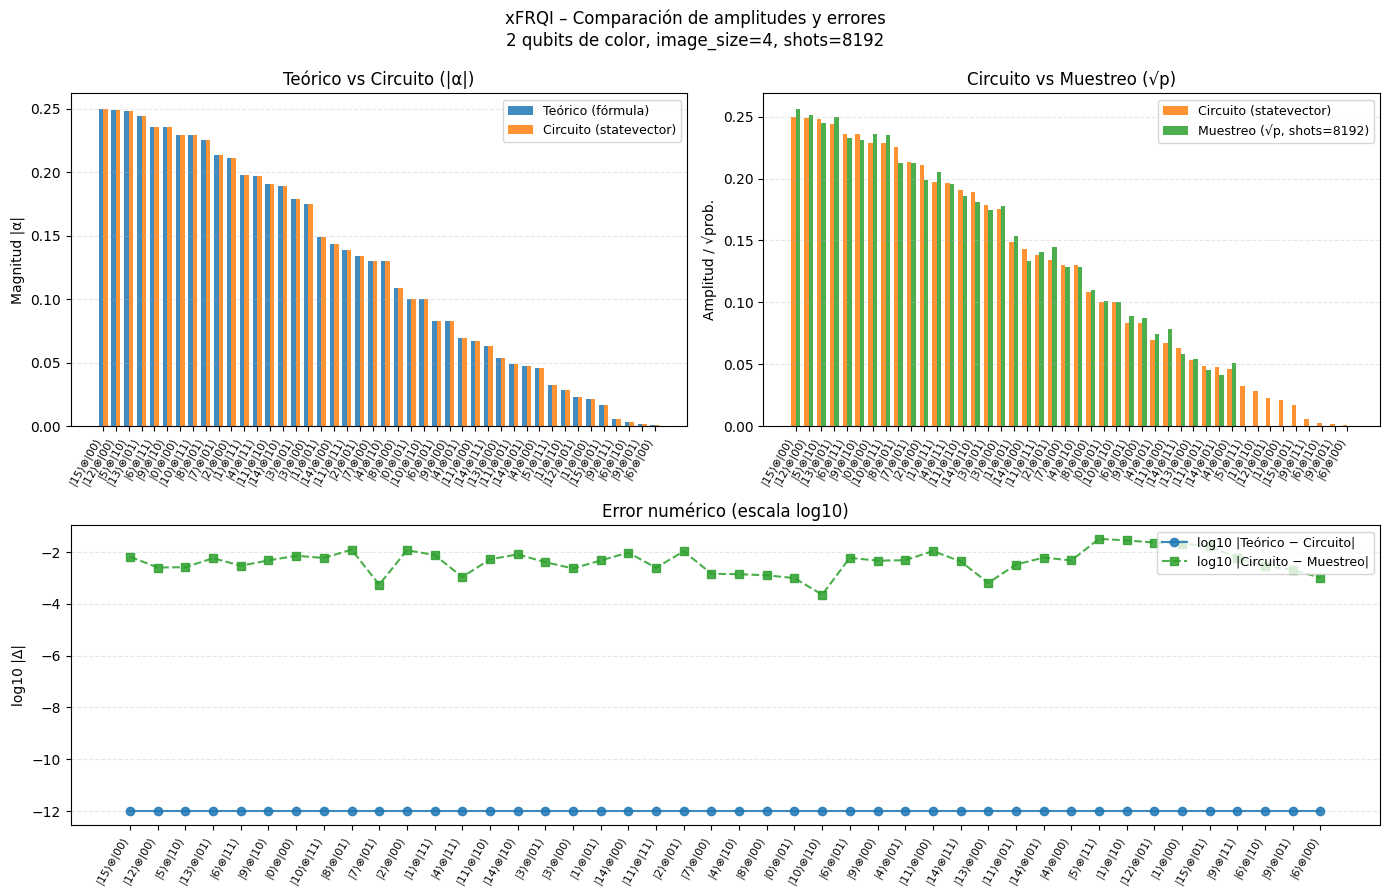

Resumen:
  Panel A (Teórico vs Circuito):   max |Δ|=8.327e-17, mean |Δ|=4.268e-17
  Panel B (Circuito vs Muestreo): max |Δ|=3.225e-02, mean |Δ|=6.890e-03


In [15]:
# ============================================================
# Comparación visual:
#   (A) Teórico (fórmula) vs Circuito (statevector)
#   (B) Circuito (statevector) vs Muestreo (√p)
#   (C) Error |Δ| en escala log10 (abajo, a todo lo ancho)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

n_color = model.n_color_qubits

# ------------------------------------------------------------
# Asegurar que 'images' tenga exactamente n_color canales
# ------------------------------------------------------------
if isinstance(images, np.ndarray):
    images = [images] * n_color
elif len(images) != n_color:
    images = [images[0]] * n_color

# ------------------------------------------------------------
# Estados: teórico (fórmula) y circuito (statevector)
# ------------------------------------------------------------
state_theo = model.theoretical_state(*images)
state_code = model.encode(*images)

amps_theo = np.abs(state_theo)
amps_code = np.abs(state_code)

# ------------------------------------------------------------
# Muestreo usando el método del módulo (cerramos figura interna)
# ------------------------------------------------------------
nz_samp, vals_samp = model.stem_plot_amplitudes(
    images,
    shots=shots,
    device=device_sampling,
    threshold=threshold_samp,
    figsize=(6, 3)
)
plt.close()

def label(idx, n_color):
    pos = idx >> n_color
    col = format(idx & ((1 << n_color) - 1), f"0{n_color}b")
    return f"|{pos}⟩⊗|{col}⟩"

# ============================================================
# Panel A: índices relevantes por umbral en teórico o circuito
# ============================================================
idx_A = sorted(
    set(np.nonzero(amps_theo > threshold_exact)[0]) |
    set(np.nonzero(amps_code > threshold_exact)[0])
)

if len(idx_A) == 0:
    K = min(32, len(amps_code))
    idx_A = list(np.argsort(amps_code)[-K:][::-1])

# Ordenar por magnitud del circuito (más relevantes primero)
idx_A = sorted(idx_A, key=lambda i: amps_code[i], reverse=True)

vt = np.array([amps_theo[i] for i in idx_A])  # Teórico |α|
vc = np.array([amps_code[i] for i in idx_A])  # Circuito |α|
labels_A = [label(i, n_color) for i in idx_A]
xA = np.arange(len(idx_A))

# ============================================================
# Panel B: unir índices de muestreo y de circuito sobre umbral
# ============================================================
idx_B = sorted(
    set(int(i) for i in nz_samp) |
    set(np.nonzero(amps_code > threshold_exact)[0])
)

if len(idx_B) == 0:
    K = min(32, len(amps_code))
    idx_B = list(np.argsort(amps_code)[-K:][::-1])

# Ordenar por magnitud del circuito también aquí
idx_B = sorted(idx_B, key=lambda i: amps_code[i], reverse=True)

d_samp = {int(i): float(v) for i, v in zip(nz_samp, vals_samp)}
vs = np.array([d_samp.get(int(i), 0.0) for i in idx_B])   # Muestreo √p
vc_b = np.array([amps_code[i] for i in idx_B])            # Circuito |α|
labels_B = [label(i, n_color) for i in idx_B]
xB = np.arange(len(idx_B))

# ============================================================
# Errores numéricos para resumen y Panel C
# ============================================================
delta_A = np.abs(vt - vc)        # Teórico vs Circuito (solo índices A)
delta_B = np.abs(vc_b - vs)      # Circuito vs Muestreo (índices B)

# Error A restringido a los índices de B (para compararlos en Panel C)
vt_on_B = np.array([amps_theo[i] for i in idx_B])
vc_on_B = np.array([amps_code[i] for i in idx_B])
delta_A_on_B = np.abs(vt_on_B - vc_on_B)

# Evitar log10(0): recortamos con un epsilon pequeño
eps = 1e-12
log_err_A = np.log10(np.maximum(delta_A_on_B, eps))
log_err_B = np.log10(np.maximum(delta_B, eps))

# ============================================================
# Dibujar: 2 paneles arriba, 1 panel ancho abajo
# ============================================================
fig = plt.figure(figsize=(14, 9))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 0.9])

axA = fig.add_subplot(gs[0, 0])
axB = fig.add_subplot(gs[0, 1])
axC = fig.add_subplot(gs[1, :])

w = 0.35

# Paleta fija y coherente
COLOR_THEO     = "#1f77b4"   # azul
COLOR_CIRCUIT  = "#ff7f0e"   # naranja
COLOR_SAMPLING = "#2ca02c"   # verde

# -----------------------------------------------------------------
# Panel A) Teórico vs Circuito
# -----------------------------------------------------------------
ax = axA
ax.bar(
    xA - w/2, vt, width=w,
    label="Teórico (fórmula)",
    alpha=0.85, color=COLOR_THEO
)
ax.bar(
    xA + w/2, vc, width=w,
    label="Circuito (statevector)",
    alpha=0.85, color=COLOR_CIRCUIT
)

ax.set_title("Teórico vs Circuito (|α|)")
ax.set_ylabel("Magnitud |α|")
ax.set_xticks(xA)
ax.set_xticklabels(labels_A, rotation=60, ha="right", fontsize=8)
ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.legend(loc="upper right", fontsize=9)

# -----------------------------------------------------------------
# Panel B) Circuito vs Muestreo
# -----------------------------------------------------------------
ax = axB
ax.bar(
    xB - w/2, vc_b, width=w,
    label="Circuito (statevector)",
    alpha=0.85, color=COLOR_CIRCUIT
)
ax.bar(
    xB + w/2, vs, width=w,
    label=f"Muestreo (√p, shots={shots})",
    alpha=0.85, color=COLOR_SAMPLING
)

ax.set_title("Circuito vs Muestreo (√p)")
ax.set_ylabel("Amplitud / √prob.")
ax.set_xticks(xB)
ax.set_xticklabels(labels_B, rotation=60, ha="right", fontsize=8)
ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.legend(loc="upper right", fontsize=9)

# -----------------------------------------------------------------
# Panel C) Error en escala log10
# -----------------------------------------------------------------
ax = axC
ax.plot(
    xB, log_err_A,
    marker="o", linestyle="-",
    alpha=0.85, color=COLOR_THEO,
    label="log10 |Teórico − Circuito|"
)
ax.plot(
    xB, log_err_B,
    marker="s", linestyle="--",
    alpha=0.85, color=COLOR_SAMPLING,
    label="log10 |Circuito − Muestreo|"
)

ax.set_title("Error numérico (escala log10)")
ax.set_ylabel("log10 |Δ|")
ax.set_xticks(xB)
ax.set_xticklabels(labels_B, rotation=60, ha="right", fontsize=8)
ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.legend(loc="upper right", fontsize=9)

# Supertítulo con info del modelo
fig.suptitle(
    f"xFRQI – Comparación de amplitudes y errores\n"
    f"{model.n_color_qubits} qubits de color, image_size={model.image_size}, shots={shots}",
    fontsize=12,
    y=0.99
)

plt.tight_layout()
plt.show()

# ============================================================
# Resumen numérico
# ============================================================
print("Resumen:")
print(f"  Panel A (Teórico vs Circuito):   max |Δ|={delta_A.max():.3e}, mean |Δ|={delta_A.mean():.3e}")
print(f"  Panel B (Circuito vs Muestreo): max |Δ|={delta_B.max():.3e}, mean |Δ|={delta_B.mean():.3e}")


## Recuperación de Imagen (xFRQI)

La función `recover(state, shots=None)` reconstruye las imágenes de cada canal a partir de un estado cuántico `|ψ⟩` del modelo xFRQI.

Trabajamos con dos modos principales:

---

### 🔹 Modo exacto (shots = None)

En este modo se parte del vector de estado completo.

- Se calculan las probabilidades conjuntas posición-color a partir de `|ψ⟩`:
  p(i, c) = |⟨i, c | ψ⟩|²

- Para cada píxel i y para cada canal k se calcula la probabilidad condicional de que el qubit de color k esté en 1 dado que la posición es i:
  
  p1(k, i) = Prob(color k = 1 | posición = i)

- A partir de esa probabilidad se invierte el mapeo FRQI para recuperar la intensidad del pixel:

  I(k, i) ≈ 255 × (2 / π) × arcsin( sqrt(p1(k, i)) )

- Cuando el modelo está implementado correctamente, la reconstrucción exacta reproduce la imagen original con error prácticamente cero.

---

### 🔹 Modo por muestreo (shots > 0)

Aquí se mide el estado repetidamente usando el backend tipo hardware (por ejemplo `default.qubit`).

- Se obtienen conteos de resultados y se estiman probabilidades mediante conteo over shots.

- La reconstrucción de las intensidades usa la misma inversión FRQI que el caso exacto, pero ahora cada probabilidad tiene ruido estadístico.

- El error típico de reconstrucción es pequeño, usualmente entre 1 y 3 niveles de gris sobre un rango de 0 a 255.

- El error decrece aproximadamente como 1 dividido entre la raíz cuadrada del número de shots.

---

### 🔹 Orden de canales y consistencia

- Si se pasa un conjunto de imágenes como:  
  (img canal 0, img canal 1, ..., img canal C-1)  

  entonces `encode` coloca el canal k en el qubit de color k.

- `recover` devuelve las imágenes en el mismo orden:  
  canal 0, canal 1, ..., canal C-1.  

- Los wires de posición van de 0 a (n_pos - 1).  
- Los wires de color comienzan en n_pos.  
- El canal 0 corresponde al bit más significativo dentro del bloque de color y el canal C-1 al menos significativo.

Esta convención se respeta en `encode`, `theoretical_state`, `recover` y en las etiquetas usadas para visualizar amplitudes.

---

### 🔹 Lectura de las métricas (MAE)

Para cada canal se reportan tres medidas:

- MAE entre imagen original y reconstrucción exacta  
  → valida la corrección del modelo y debe ser muy pequeña.

- MAE entre imagen original y reconstrucción por muestreo  
  → indica cuánto afecta el ruido estadístico.

- MAE entre reconstrucción exacta y reconstrucción por muestreo  
  → mide directamente el efecto del muestreo independientemente de la imagen original.

En resumen:

- El modo exacto sirve para validar la implementación del modelo xFRQI.  
- El modo por muestreo aproxima el comportamiento de un backend real y revela cuánta variación introduce el ruido estadístico del muestreo.


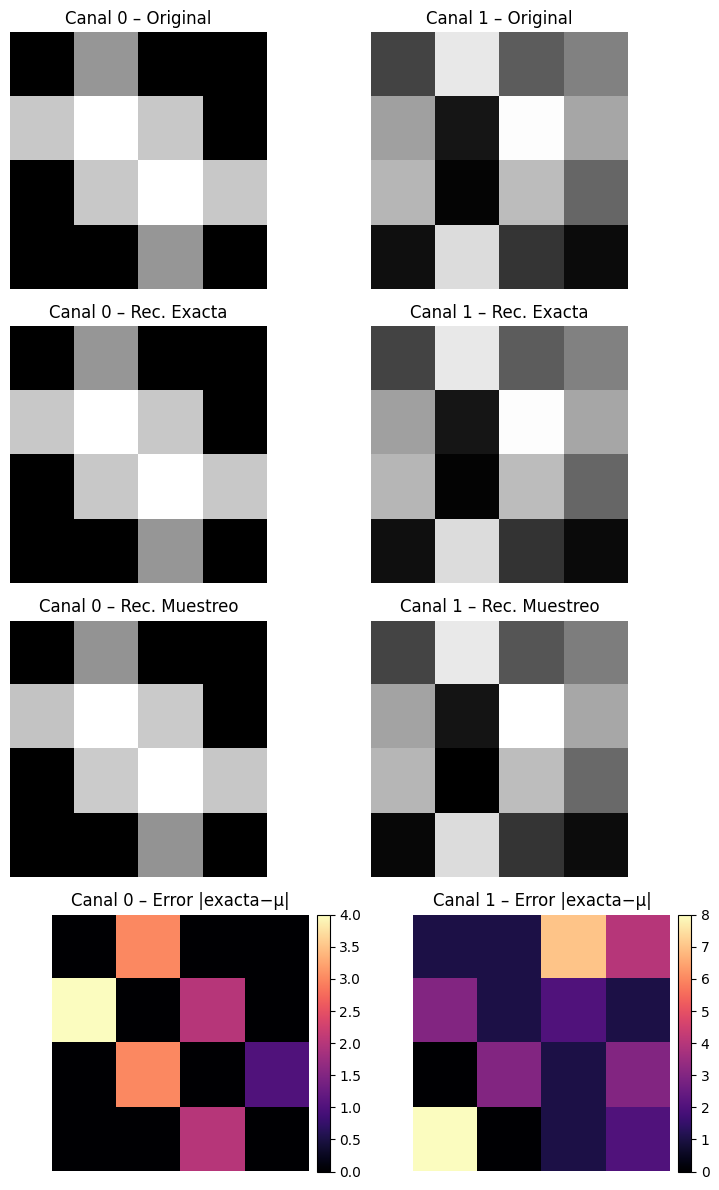

Resumen de errores (MAE) por canal:

Canal 0:
  MAE(Original, Rec. Exacta)   = 0.000
  MAE(Original, Rec. Muestreo) = 0.938
  MAE(Rec. Exacta, Muestreo)   = 0.938

Canal 1:
  MAE(Original, Rec. Exacta)   = 0.188
  MAE(Original, Rec. Muestreo) = 2.312
  MAE(Rec. Exacta, Muestreo)   = 2.375


In [16]:
# ============================================================
# Reconstrucción exacta vs muestreo
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

nC = model.n_color_qubits

# Asegurar que 'images' tenga exactamente nC canales
if isinstance(images, np.ndarray):
    images = [images] * nC
elif len(images) != nC:
    images = [images[0]] * nC

# 1) Estado exacto (vector de estado desde el circuito)
state = model.encode(*images)

# 2) Reconstrucción exacta (sin muestreo, usando statevector)
rec_exact = model.recover(state, shots=None)  # lista de imágenes por canal

# 3) Reconstrucción por muestreo (usando device_sampling de forma temporal)
_backup = model.device_str
model.device_str = device_sampling  # usar backend de muestreo para recover()
rec_samp = model.recover(state, shots=shots)  # lista de imágenes por canal
model.device_str = _backup  # restaurar backend original

# 4) Visualización comparativa por canal
#    Filas:
#      0: Original
#      1: Reconstrucción exacta
#      2: Reconstrucción muestreo
#      3: Error |exacta − muestreo|
fig_rows = 4
fig_cols = nC
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(4 * nC, 3 * fig_rows))

if nC == 1:
    # Normalizar shape para indexar axs[fila, col]
    axs = np.array([[axs[0]], [axs[1]], [axs[2]], [axs[3]]])

for k in range(nC):
    orig = images[k]
    rex  = rec_exact[k]
    rsm  = rec_samp[k]

    err_map = np.abs(rex.astype(float) - rsm.astype(float))

    # Fila 0: original
    ax = axs[0, k]
    ax.imshow(orig, cmap="gray", vmin=0, vmax=255)
    ax.set_title(f"Canal {k} – Original")
    ax.axis("off")

    # Fila 1: reconstrucción exacta
    ax = axs[1, k]
    ax.imshow(rex, cmap="gray", vmin=0, vmax=255)
    ax.set_title(f"Canal {k} – Rec. Exacta")
    ax.axis("off")

    # Fila 2: reconstrucción por muestreo
    ax = axs[2, k]
    ax.imshow(rsm, cmap="gray", vmin=0, vmax=255)
    ax.set_title(f"Canal {k} – Rec. Muestreo")
    ax.axis("off")

    # Fila 3: mapa de error |exacta − muestreo|
    ax = axs[3, k]
    vmax_err = max(err_map.max(), 1.0)
    im = ax.imshow(err_map, cmap="magma", vmin=0, vmax=vmax_err)
    ax.set_title(f"Canal {k} – Error |exacta−μ|")
    ax.axis("off")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)

plt.tight_layout()
plt.show()

# 5) Errores simples (MAE) por canal
def mae(a, b):
    a = a.astype(np.float32)
    b = b.astype(np.float32)
    return np.mean(np.abs(a - b))

print("Resumen de errores (MAE) por canal:")
for k in range(nC):
    orig = images[k]
    rex  = rec_exact[k]
    rsm  = rec_samp[k]

    mae_exact = mae(orig, rex)
    mae_samp  = mae(orig, rsm)
    mae_ex_sm = mae(rex,  rsm)

    print(f"\nCanal {k}:")
    print(f"  MAE(Original, Rec. Exacta)   = {mae_exact:.3f}")
    print(f"  MAE(Original, Rec. Muestreo) = {mae_samp:.3f}")
    print(f"  MAE(Rec. Exacta, Muestreo)   = {mae_ex_sm:.3f}")


## Medidas de Correlación Cuántica

En un sistema cuántico multipartito, las correlaciones no se limitan a dependencias estadísticas: también incluyen efectos puramente cuánticos como la coherencia global y la no separabilidad entre subsistemas. Para capturar estas relaciones de manera unificada utilizamos la **información mutua cuántica**, una magnitud basada en la entropía de von Neumann.

La entropía de un subsistema cuantifica el grado de mezcla inducido por su interacción con el resto del sistema. Cuando combinamos estas entropías en diferentes configuraciones obtenemos un conjunto de medidas que describen:

- la mezcla global del estado total  
- la correlación entre posición e intensidades codificadas  
- la interacción interna entre los distintos qubits de color  
- el carácter tripartito de la correlación en modelos con más de un canal  
- la diferencia entre información clásica y cuántica en la distribución posicional

Estas cantidades permiten evaluar cómo fluye la información en el modelo xFRQI y cómo se distribuyen las correlaciones entre la parte posicional y los canales de color. Esto resulta especialmente útil al comparar distintos patrones de entrada, estudiar ruido inducido por el muestreo o analizar la sensibilidad del modelo frente a transformaciones locales.


In [17]:
# ============================================================
# Métricas de información: entropías e información mutua
# ============================================================

# 1) Entropías y correlaciones (del estado exacto)
stats = model.analyze_state(state)

n_pos = model.n_position_qubits
n_col = model.n_color_qubits

# Máximos teóricos (en bits) para normalizar
H_pos_max = n_pos
H_col_max = 1.0          # cada qubit de color como sistema de 2 niveles
H_total_max = model.n_qubits

# Construimos una lista de (clave, valor, Hmax) para imprimir ordenado
rows = []

# Entropías globales
rows.append(("H_total",          stats.get("H_total", np.nan),          H_total_max))
rows.append(("H_position",       stats.get("H_position", np.nan),       H_pos_max))

# Entropías y MI por cada qubit de color
for k in range(n_col):
    rows.append((f"H_color{k}",            stats.get(f"H_color{k}", np.nan),        H_col_max))
    rows.append((f"I(color{k}:position)",  stats.get(f"I(color{k}:position)", np.nan),   None))
    rows.append((f"H_color{k}|position",   stats.get(f"H_color{k}|position", np.nan),    H_col_max))

# Términos conjuntos si hay ≥2 qubits de color
if n_col >= 2:
    rows.append(("H_colors_joint",        stats.get("H_colors_joint", np.nan),     n_col))
    rows.append(("I(color0:color1)",      stats.get("I(color0:color1)", np.nan),   None))
    rows.append(("H_color0|color1",       stats.get("H_color0|color1", np.nan),    H_col_max))
    rows.append(("H_color1|color0",       stats.get("H_color1|color0", np.nan),    H_col_max))
    rows.append(("I3(position:color0:color1)", stats.get("I3(position:color0:color1)", np.nan), None))

# Imprimir en forma de pequeña tabla
print("— Entropías y correlaciones (estado exacto) —")
print(f"{'Magnitud':>28s}  {'Valor [bits]':>14s}  {'Rel. a Hmax':>12s}")
print("-" * 60)
for name, val, hmax in rows:
    if np.isnan(val):
        continue
    if hmax is not None and hmax > 0:
        rel = val / hmax
        print(f"{name:>28s}  {val:14.6f}  {rel:12.3f}")
    else:
        print(f"{name:>28s}  {val:14.6f}  {'   —':>12s}")

# ============================================================
# 2) Información mutua clásica color ↔ posición
# ============================================================

# a) Exacta (a partir de |ψ|^2)
mi_exact = model.mi_samples(*images, shots=None)

# b) Estimada por muestreo (usando backend de muestreo)
mi_emp = model.mi_samples(*images, shots=shots, backend=device_sampling)

rel_err = abs(mi_emp - mi_exact) / mi_exact if mi_exact != 0 else np.nan

print("\n— Información mutua color ↔ posición —")
print(f"{'MI exacta':>20s} = {mi_exact:.6f} bits")
print(f"{'MI muestreo':>20s} = {mi_emp:.6f} bits  (shots = {shots})")
print(f"{'Error relativo':>20s} = {rel_err:.3e}")

# ============================================================
# 3) (Opcional) MI por bloques (coarse graining de la posición)
# ============================================================
# Ejemplo: si image_size = 8 ⇒ n_pos_qubits = 6 ⇒ se pueden elegir n_blocks = 16 (4×4 bloques).
# Descomenta si quieres estimar MI con coarse graining espacial:
#
# n_blocks = 16
# mi_emp_blocks = model.mi_samples(*images, shots=shots,
#                                  backend=device_sampling,
#                                  n_blocks=n_blocks)
# print(f\"MI por muestreo (n_blocks = {n_blocks}) = {mi_emp_blocks:.6f} bits\")


— Entropías y correlaciones (estado exacto) —
                    Magnitud    Valor [bits]   Rel. a Hmax
------------------------------------------------------------
                     H_total        0.000000         0.000
                  H_position        1.681918         0.420
                    H_color0        0.928084         0.928
          I(color0:position)        1.848353             —
           H_color0|position       -0.920269        -0.920
                    H_color1        0.761649         0.762
          I(color1:position)        1.515484             —
           H_color1|position       -0.753834        -0.754
              H_colors_joint        1.681918         0.841
            I(color0:color1)        0.007815             —
             H_color0|color1        0.920269         0.920
             H_color1|color0        0.753834         0.754
  I3(position:color0:color1)        0.000000             —

— Información mutua color ↔ posición —
           MI exacta = 1.25

### Resumen conceptual

- Las **entropías** describen la mezcla y complejidad de cada subsistema.
- Las **informaciones mutuas** describen el grado de dependencia entre subsistemas.
- Combinadas, estas medidas permiten analizar cómo **la estructura espacial de la imagen** induce correlaciones en el estado cuántico.
- En modelos xFRQI con múltiples canales, estos análisis permiten evaluar si los canales codifican información independiente, redundante o complementaria.

Estas interpretaciones hacen que xFRQI no solo sea un método de codificación, sino también una herramienta para estudiar correlaciones cuánticas en imágenes y mapas de características.

## Referencias Adicionales

1. Sánchez M. A. M., Sun G. H., Dong S. H.  
    Correlation Property of Multipartite Quantum Image.  
   International Journal of Theoretical Physics, volumen 58, páginas 3773–3796 (2019).  
   https://doi.org/10.1007/s10773-019-04247-9

2. Yan F., Iliyasu A. M., Venegas-Andraca S. E.  
   A survey of quantum image representations.  
   Quantum Information Processing, volumen 15, páginas 1–35 (2016).  
   https://doi.org/10.1007/s11128-015-1195-6

3. Documentación de PennyLane  
   Sección sobre mediciones y operadores de observación.  
   https://docs.pennylane.ai/en/stable/introduction/measurements.html
